# Mask R-CNN - Train on Zebrafish
 

In [21]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from tqdm import tqdm, tqdm_notebook

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

import trackpy as tp
import pims
import h5py

# rla IJ mask and roi functions
import ij_mask_roi
from ij_roi_convert import *

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to COCO trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [ ]:
# SET IMAGE SIZE
IMAGE_SIZE = 800

#We have a small stack, so load it all into memory
img = ij_mask_roi.openTifImage('path/to/image.tif')
images_train = img[1:80,0:3]  # images are in the first 3 channels
images_test = img[80:100,0:3]  # images are in the first 3 channels
masks_train = (img[1:80,3:] > 0).astype(np.int)   # masks are in the last 5 channels
masks_test = img[80:100,3:]  # masks are in the last 5 channels
images_holdout = img[100:,0:3]
# masks_holdout =  
del img

#Make sure we loaded the right thing
print('Training images:',len(images_train), ' ','Test images:',len(images_test))
plt.imshow(np.rollaxis(images_train[0],0,3))
plt.show()
fig = plt.figure()                          #Make a new figure
ax = fig.add_subplot(111)                   #Add subplot to that figure, get ax
for i, ch in enumerate(masks_train[0]):
    ax.imshow(masks_train[0,i],   aspect='auto', cmap='Greys', vmin=0, vmax=1)
plt.show()

# # SET IMAGE DIRECTORIES
# IMAGE_TRAIN_DIR = os.path.join(ROOT_DIR, 'rla/zebrafish/jpg/train/')
# IMAGE_VAL_DIR = os.path.join(ROOT_DIR, 'rla/zebrafish/jpg/test/')
# images_root = 'rla/zebrafish/jpg'
# zip_file_root = 'rla/zebrafish/ROIs'

# IMAGE_LIST = get_image_paths(images_root)

# zip_paths = get_zip_paths(zip_file_root)
# # LOAD THE BOUNDING BOX LIST
# # List of numpy mask arrays of shape (instance, height, width)
# # Indexed the same as IMAGE_LIST
# BBOX_DICT = rois_to_bboxes(zip_paths)#pickle.load(open('rla/zebrafish/bboxes.pickle', 'rb'))

# assert len(BBOX_DICT) == len(IMAGE_LIST), "If an ROI is in every frame, the BBOX_DICT should be the same length as the IMAGE_LIST"

In [3]:
#setup slack notifications:
from slacker import Slacker
from secret.keys import slack_api_key
slack = Slacker(slack_api_key)
def send_slack(message):
    slack.chat.post_message('#notify-richard', message)

In [4]:
for root, dirs, files in os.walk(ROOT_DIR):
    print(dirs)
    break
    

['samples', '__pycache__', 'assets', 'rla', '.git', 'secret', 'images', 'mrcnn', '.ipynb_checkpoints', 'logs']


## Configurations

In [5]:
class imgConfig(Config):
    """Configuration for training.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "zebrafish"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 zebrafish

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
#     IMAGE_MIN_DIM = 448
#     IMAGE_MAX_DIM = 768  # Image is 800px, but must be divisible by 64

    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 100 #1000

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    #VALIDATION_STEPS = 5
    
config = imgConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

## Notebook Preferences

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [7]:
class imgDataset(utils.Dataset):
    """
    Load images from file and generate object instance masks 
    from IJ masks and roi.zip files
    """
    
#     def __init__(self, images, masks):
#         self.images = images
#         self.masks = masks

    def add_images(self, images, masks, height, width, orig_height=None, orig_width=None, ):
        """
        Add image path info from directory
        INPUT:
            images: array of numpy images
            height: image height
            width: image width
            orig_height: if padded, store original image height here
            orig_width: if padded, store original image width here
        OUTPUT:
            NONE
            Adds image info to the Dataset class to be called later
        """
#         images=self.images
        
        # Add classes
        dataset_name = 'zebrafish'
        self.add_class(dataset_name, 1, "zebrafish")
        
        for i,img in enumerate(images):
            self.add_image(dataset_name, image_id=i, image=img, mask=masks[i], path='',
                           width=width, height=height,
                           orig_width=orig_width, orig_height=orig_height
                           )
        print('{} images added.'.format(len(self.image_info)))


    def resize(self, image, max_dim):
        # Get new height and width
        h, w = image.shape[:2]
        top_pad = (max_dim - h) // 2
        bottom_pad = max_dim - h - top_pad
        left_pad = (max_dim - w) // 2
        right_pad = max_dim - w - left_pad
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        return image
    
    def load_image(self, image_id,):
        """
        Load image from image_info dictionary
        """
#         images=self.images
#         assert isinstance(images, np.ndarray)        
        info = self.image_info[image_id]
        img = info['image'] #images[info['id']]
        image = np.rollaxis(img,0,3)
        
        return image
#         """
#         Load image from image_info dictionary
#         """
#         info = self.image_info[image_id]
#         path = info['path']
#         # print(path)        #print each image to troubleshoot where failures occur
#         image = imread(path)
        
#         return image

    def load_mask(self, image_id, ):
        """
        Generate instance masks using IJ masks and roi.zip for the given image ID.
        """
#         masks=self.masks
#         assert isinstance(masks, np.ndarray)
        info = self.image_info[image_id]
        mask_array = info['mask'] # masks[info['id']]
        mask_array = np.rollaxis(mask_array,0,3)
        mask_classes = []
        for m in range(mask_array.shape[2]):
            mask_classes.append(1) # We only have one zebrafish class
        return mask_array.astype(np.bool).astype(np.uint8), np.array(mask_classes, dtype=np.uint8)
#         info = self.image_info[image_id]
#         bboxes = info['bboxes']
#         class_ids = []
#         for bbox in bboxes:
#             class_ids.append(1) # We only have one zebrafish class
            
#         masks = bbox_to_masks(bboxes, info['width'], info['height'])
#         class_ids = np.asarray(class_ids)
            
#         return masks.astype(np.bool), class_ids.astype(np.int32)
# #         return mask_arrays.astype(np.bool), mask_classes.astype(np.int32)

In [8]:
# Training dataset
dataset_train = imgDataset()
dataset_train.add_images(images_train, masks_train, height=448, width=800) # 4096, 4096,
dataset_train.prepare()

# Validation dataset
dataset_val = imgDataset()
dataset_val.add_images(images_test, masks_test, height=448, width=800)
dataset_val.prepare()

79 images added.
20 images added.


In [9]:
test_img = dataset_train.load_image(1)
print(type(test_img))
print(test_img.shape)

test_mask, test_cids = dataset_train.load_mask(9)
print(type(test_mask))
print(test_mask.shape)

# test_roi, test_cids = dataset_train.get_source_class_id

<class 'numpy.ndarray'>
(448, 800, 3)
<class 'numpy.ndarray'>
(448, 800, 5)


In [11]:
# for imid in dataset_val.image_ids:
#     print(imid, dataset_val.image_info[imid]['name'])
    

In [12]:
# for imid in dataset_train.image_ids:
#     test_mask, test_cids = dataset_train.load_mask(imid)
#     print(imid, test_mask.shape, test_cids.shape)
#     break

In [13]:
# info = dataset_train.image_info[1]
# # print(info['mask_path'])
# # print(info['roi_path'])
# roi_arrays, roi_classes = ij_mask_roi.getROIobjects(info['roi_path'], 2, height=info['height'], width=info['width'])
# print(roi_arrays.shape)
# print(roi_classes.shape)

In [ ]:
# Load and display random training samples
image_ids = np.random.choice(dataset_train.image_ids, 3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
#     display_top_masks(image, mask, class_ids, dataset_train.class_names)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

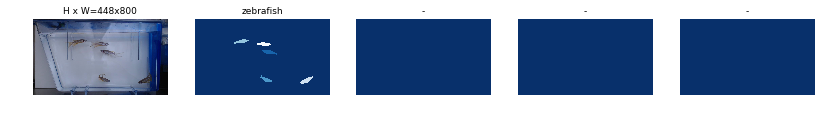

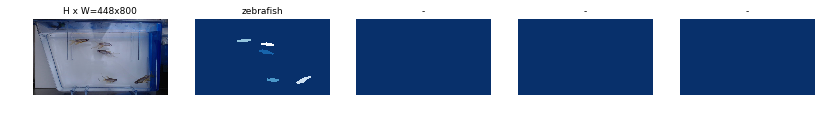

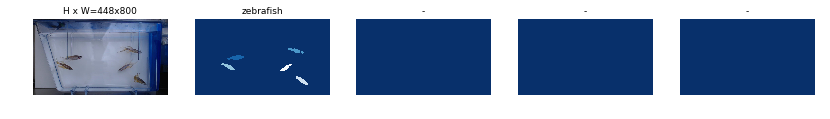

In [15]:
# Load and display random validation samples
image_ids = np.random.choice(dataset_val.image_ids, 3)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

## Create Model

In [16]:
def load_image_gt(dataset, config, image_id, augment=False, augmentation=None,
                  use_mini_mask=False):
    """Load and return ground truth data for an image (image, mask, bounding boxes).

    augment: (deprecated. Use augmentation instead). If true, apply random
        image augmentation. Currently, only horizontal flipping is offered.
    augmentation: Optional. An imgaug (https://github.com/aleju/imgaug) augmentation.
        For example, passing imgaug.augmenters.Fliplr(0.5) flips images
        right/left 50% of the time.
    use_mini_mask: If False, returns full-size masks that are the same height
        and width as the original image. These can be big, for example
        1024x1024x100 (for 100 instances). Mini masks are smaller, typically,
        224x224 and are generated by extracting the bounding box of the
        object and resizing it to MINI_MASK_SHAPE.

    Returns:
    image: [height, width, 3]
    shape: the original shape of the image before resizing and cropping.
    class_ids: [instance_count] Integer class IDs
    bbox: [instance_count, (y1, x1, y2, x2)]
    mask: [height, width, instance_count]. The height and width are those
        of the image unless use_mini_mask is True, in which case they are
        defined in MINI_MASK_SHAPE.
    """
    # Load image and mask
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    original_shape = image.shape
    image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)
    mask = utils.resize_mask(mask, scale, padding, crop)

    # Random horizontal flips.
    # TODO: will be removed in a future update in favor of augmentation
    if augment:
        logging.warning("'augment' is deprecated. Use 'augmentation' instead.")
        if random.randint(0, 1):
            image = np.fliplr(image)
            mask = np.fliplr(mask)

    # Augmentation
    # This requires the imgaug lib (https://github.com/aleju/imgaug)
    if augmentation:
        import imgaug

        # Augmenters that are safe to apply to masks
        # Some, such as Affine, have settings that make them unsafe, so always
        # test your augmentation on masks
        MASK_AUGMENTERS = ["Sequential", "SomeOf", "OneOf", "Sometimes",
                           "Fliplr", "Flipud", "CropAndPad",
                           "Affine", "PiecewiseAffine"]

        def hook(images, augmenter, parents, default):
            """Determines which augmenters to apply to masks."""
            return augmenter.__class__.__name__ in MASK_AUGMENTERS

        # Store shapes before augmentation to compare
        image_shape = image.shape
        mask_shape = mask.shape
        # Make augmenters deterministic to apply similarly to images and masks
        det = augmentation.to_deterministic()
        image = det.augment_image(image)
        # Change mask to np.uint8 because imgaug doesn't support np.bool
        mask = det.augment_image(mask.astype(np.uint8),
                                 hooks=imgaug.HooksImages(activator=hook))
        # Verify that shapes didn't change
        assert image.shape == image_shape, "Augmentation shouldn't change image size"
        assert mask.shape == mask_shape, "Augmentation shouldn't change mask size"
        # Change mask back to bool
        mask = mask.astype(np.bool)

    # Note that some boxes might be all zeros if the corresponding mask got cropped out.
    # and here is to filter them out
    _idx = np.sum(mask, axis=(0, 1)) > 0
    print(_idx)
    mask = mask[:, :, _idx]
    print(mask)
    class_ids = class_ids[_idx]
    # Bounding boxes. Note that some boxes might be all zeros
    # if the corresponding mask got cropped out.
    # bbox: [num_instances, (y1, x1, y2, x2)]
    bbox = utils.extract_bboxes(mask)

    # Active classes
    # Different datasets have different classes, so track the
    # classes supported in the dataset of this image.
    active_class_ids = np.zeros([dataset.num_classes], dtype=np.int32)
    source_class_ids = dataset.source_class_ids[dataset.image_info[image_id]["source"]]
    active_class_ids[source_class_ids] = 1

    # Resize masks to smaller size to reduce memory usage
    if use_mini_mask:
        mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)

    # Image meta data
    image_meta = compose_image_meta(image_id, original_shape, image.shape,
                                    window, scale, active_class_ids)

    return image, image_meta, class_ids, bbox, mask

In [17]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [20]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    # model.load_weights('/home/rla/deeplearn/Mask_RCNN/logs/zebrafish20181015T1318/mask_rcnn_zebrafish_0065.h5')  #
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 60


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
try:
    model.train(dataset_train, dataset_val, 
        learning_rate=config.LEARNING_RATE, 
        epochs=40, 
        layers='heads')
except Exception as e:
    print(e)
    print('DONE')
    send_slack('Exception while training. Run ended prematurely.')
    raise e
send_slack('All runs complete.')
print('DONE')

In [9]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
Starting at epoch 0. LR=0.0002

Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b      

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 86s - loss: 11.4006 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.8409 - mrcnn_class_loss: 0.1576 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1977 - val_loss: 11.4376 - val_rpn_class_loss: 0.0220 - val_rpn_bbox_loss: 1.0068 - val_mrcnn_class_loss: 0.1172 - val_mrcnn_bbox_loss: 0.0683 - val_mrcnn_mask_loss: 0.1278


In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [7]:
class InferenceConfig(imgConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, 'logs/zebrafish20181015T1318/mask_rcnn_zebrafish_0053.h5') # try epoch 9, 26, 53
# model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /media/rla/deeplearn/Mask_RCNN/logs/zebrafish20181015T1318/mask_rcnn_zebrafish_0053.h5
Re-starting from epoch 53


In [23]:
# Holdout dataset
dataset_hold = imgDataset()
dataset_hold.add_images(images_holdout, [0 for i in images_holdout], height=448, width=800)
dataset_hold.prepare()

200 images added.


In [34]:
from matplotlib.patches import Polygon
def save_instances(save_path, image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or visualize.random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            x = random.randint(x1, (x1 + x2) // 2)
            caption = "{:.3f}".format(score) if score else label  # show score only
            # caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

#         # Mask
#         mask = masks[:, :, i]
#         if show_mask:
#             masked_image = visualize.apply_mask(masked_image, mask, color)

#         # Mask Polygon
#         # Pad to ensure proper polygons for masks that touch image edges.
#         padded_mask = np.zeros(
#             (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
#         padded_mask[1:-1, 1:-1] = mask
#         contours = visualize.find_contours(padded_mask, 0.5)
#         for verts in contours:
#             # Subtract the padding and flip (y, x) to (x, y)
#             verts = np.fliplr(verts) - 1
#             p = Polygon(verts, facecolor="none", edgecolor=color)
#             ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    plt.savefig(save_path, quality=100)
#     if auto_show:
#         plt.show()
    plt.close()
        

In [39]:
# SAVE INSTANCE OUTPUT IMAGES
from tqdm import tqdm, tqdm_notebook
# for id in dataset_hold.image_ids[50:]:
for root, f, files in os.walk('rla/zebrafish/holdout/'):
#     files = files.sort()
#     print(root, f, files)
    files.sort()
    for file in tqdm(files):
        save_path = 'rla/zebrafish/output/holdout/scores_e26_{}'.format(file)
        image = plt.imread(root + file, 'jpg') #dataset_hold.load_image(id)
        result = model.detect([image])[0]
        class_ids = result['class_ids']
        masks = result['masks']
        rois = result['rois']
        scores = result['scores']
        save_instances(save_path, image, rois, masks, class_ids, class_names={0:'background', 1:'zebrafish'}, scores=scores, show_mask=False, colors=[(0,1,0,1),(0,1,0,1),(0,1,0,1),(0,1,0,1),(0,1,0,1),(0,1,0,1),(0,1,0,1),(0,1,0,1),])
#         break
print('DONE')

100%|██████████| 300/300 [02:14<00:00,  2.19it/s]

DONE


In [8]:
# GET INSTANCE ROIS
from tqdm import tqdm, tqdm_notebook
# for id in dataset_hold.image_ids[50:]:
detection_masks = {}
detection_rois = {}
for root, f, files in os.walk('rla/zebrafish/holdout/'):
#     files = files.sort()
#     print(root, f, files)
    files.sort()
    for i, file in enumerate(tqdm(files)):
        save_path = 'rla/zebrafish/output/holdout/scores_e26_{}'.format(file)
        image = plt.imread(root + file, 'jpg') #dataset_hold.load_image(id)
        result = model.detect([image])[0]
        class_ids = result['class_ids']
        masks = result['masks']
        rois = result['rois']
        scores = result['scores']
        
        detection_masks[file] = masks
        detection_rois[file] = rois
#         save_instances(save_path, image, rois, masks, class_ids, class_names={0:'background', 1:'zebrafish'}, scores=scores, show_mask=False, colors=[(0,1,0,1),(0,1,0,1),(0,1,0,1),(0,1,0,1),(0,1,0,1),(0,1,0,1),(0,1,0,1),(0,1,0,1),])
        if i > 10:
            break
print('DONE')

  4%|▎         | 11/300 [00:06<02:07,  2.26it/s]

DONE


In [ ]:
keys = [key for key in detection_rois.keys()]
keys.sort()
df_positions = pd.DataFrame()
for i, key in enumerate(keys):
    positions = detection_rois[key]
    for p in positions:
        # position array is (y1, x1, y2, x2)
        x = (p[1]+p[3])/2
        y = (p[0]+p[2])/2
        df_positions = df_positions.append({'x':x, 'y':y, 'frame':i, 'image':key}, ignore_index=True)
df_positions

In [ ]:
import trackpy as tp
traj = tp.link_df(df_positions, 100, memory=3)
traj

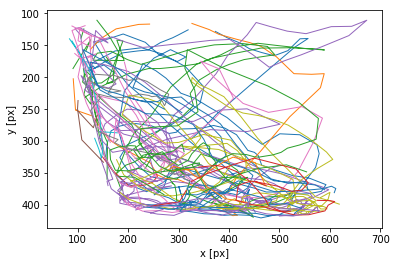

In [12]:
plt.figure()
tp.plot_traj(traj);

In [ ]:
# CREATE A COLOR CYCLE FOR OVERLAY
colors = []
tab20 = plt.get_cmap('tab20')
# get dark shades
for i in range(10):
    colors.append(tab20(i/10))
# get light shades
for i in range(10):
    colors.append(tab20((i/10)+1/20))
# more dark shades since we have more than 20 trajectories
for i in range(10):
    colors.append(tab20(i/10))
print('{} colors in cycle:'.format(len(colors)))
colors

In [ ]:
X = [x for x in range(13)]
for x in range(13):
    X.append(x)
Y = [1 for x in range(13)]
for x in range(13):
    Y.append(2)
lbl = [1,2,3,4,7,0,7,0,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,]
plt.scatter(X,Y,c=lbl,cmap=matplotlib.colors.ListedColormap(colors))

In [68]:
for i, row in df.iterrows():
    print(row['particle'])

1
4
0


In [67]:
row['particle']

0

In [72]:
image.shape

(448, 800, 3)

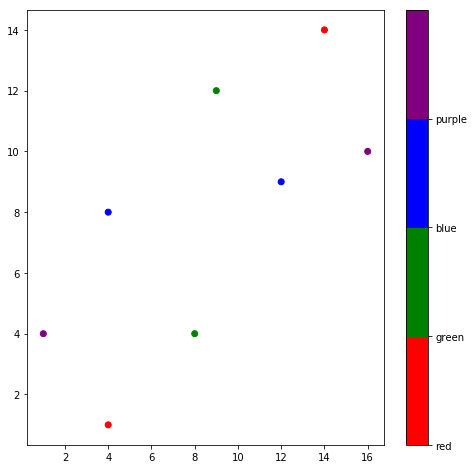

In [93]:
x = [4,8,12,16,1,4,9,14]
y = [1,4,9,10,4,8,12,14]
label = [0,1,2,3,3,2,1,0]
colors = ['red','green','blue','purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)

In [100]:
len(colors)

30

In [102]:
colors[1]

(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)

100%|██████████| 300/300 [00:32<00:00,  7.74it/s]


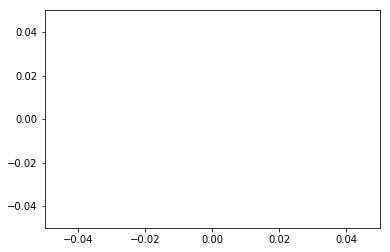

In [107]:
# OVERLAY PARTICLE IDS ON IMAGES
img_dir = 'rla/zebrafish/holdout/'
# get image names from df
img_names = traj['image'].unique()
img_names.sort()
# get trajectory ids from df
traj_ids = traj['particle'].unique()
traj_ids.sort()
# assign color to each traj_id
for i, image in enumerate(tqdm(img_names)):
    df = traj[traj['image']==image]
    save_path = 'rla/test_{}'.format(image) # 'rla/zebrafish/output/holdout/track_e53_{}'.format(image)
    image = plt.imread(img_dir + image, 'jpg') #dataset_hold.load_image(id)
    dpi = 100
    y,x,c = image.shape
    plt.autoscale(tight=True)
    plt.figure(frameon=False, figsize=(x/dpi,y/dpi), dpi=dpi)
    plt.imshow(image)
    # must have exact number of colors in colormap or colors aren't ploted as expected
    # plt.scatter(df['x'],df['y'],c=df['particle'],cmap=matplotlib.colors.ListedColormap(colors))
    
    for idx, row in df.iterrows():
        plt.scatter(row['x'],row['y'],c=colors[row['particle']])  # ,cmap=matplotlib.colors.ListedColormap(colors[])
        plt.annotate(row['particle'],(row['x'],row['y']))
    plt.axis('off')
#     plt.savefig(save_path, quality=100, bbox_inches='tight', pad_inches=0, dpi=dpi)
    
#     print(df)
#     plt.show()
    plt.close()
#     if i>=10:
#         break

In [ ]:
# # Save a random image
# image_id = random.choice(dataset_val.image_ids)
# original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#     modellib.load_image_gt(dataset_val, inference_config, 
#                            image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_bbox)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

# save_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  231.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (5, 4)                min:  298.00000  max:  904.00000  int32
gt_bbox                  shape: (5, 4)                min:  298.00000  max:  904.00000  int32
gt_mask                  shape: (1024, 1024, 5)       min:    0.00000  max:    1.00000  uint8


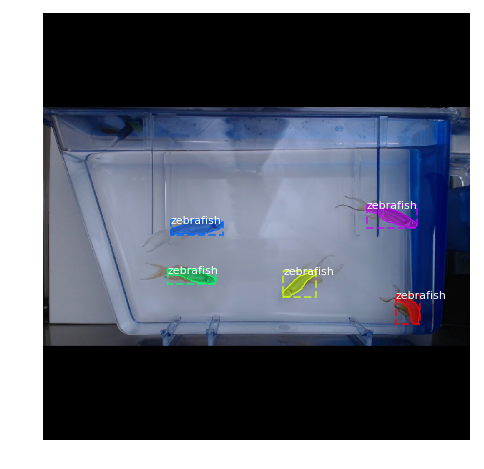

In [29]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  229.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  125.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


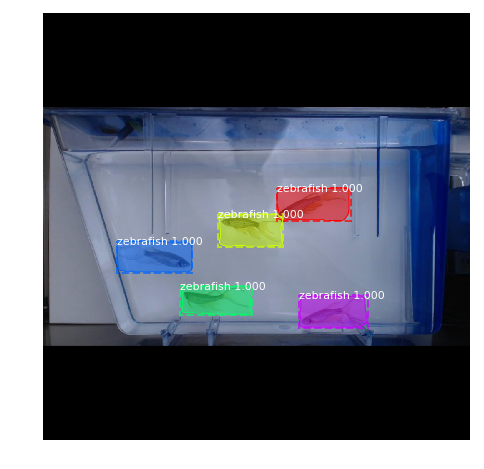

In [23]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95


SAVE: test
(448, 800, 4)


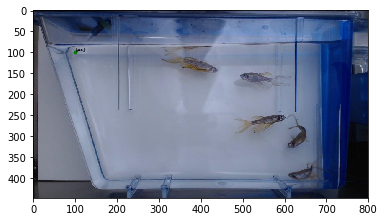

In [98]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def save_image_fix_dpi(image_data, dpi=100, filename=None):
    shape=np.shape(image_data)[0:2][::-1]
    size = [float(i)/dpi for i in shape]

    fig = plt.figure()
    fig.set_size_inches(size)
    fig.set_dpi(dpi)
    ax = plt.Axes(fig,[0,0,1,1])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(image_data)
    ax.scatter(100,100,c='g')  # ,cmap=matplotlib.colors.ListedColormap(colors[])
    ax.annotate('test',(100,100))
    
    if filename:
        print('SAVE:',filename)
    # USE THIS TO SAVE TO FILE
    #  fig.savefig('out.jpg', dpi=dpi)
    
    # USE THIS TO GET THE PIXELS
    fig.canvas.draw()  # draw the renderer
    pix = np.array(fig.canvas.renderer._renderer)  # dump pixels into a numpy array
    plt.close() # so we don't display the image after drawing it
    
    return pix
    
data = mpimg.imread('test_zf_stack_f6_small0240.jpg')
pix = save_image_fix_dpi(data, filename='test')
print(pix.shape)
plt.imshow(pix)


In [101]:
mp4 = pims.Video('rla/zebrafish/448p WIN_20181013_16_26_22_Pro.mp4')

# Save detection results to hdf5

In [115]:
tot_digits = len(mp4)
for i, image in enumerate(tqdm(mp4)):
    result = model.detect([image])[0]
    class_ids = result['class_ids']
    masks = result['masks']
    rois = result['rois']
    scores = result['scores']
    with h5py.File('rla/zebrafish/detection_results_e53.hdf5') as f:
        num = str(i)
        while len(num)<tot_digits:
            num = '0'+num  # add zeros to frame so that we can enumerate later
        f.create_dataset('masks/{}'.format(num), data=masks)
        f.create_dataset('rois/{}'.format(num), data=rois)
        f.create_dataset('scores/{}'.format(num), data=scores)

100%|██████████| 74391/74391 [9:12:08<00:00,  2.29it/s]


In [28]:
for i in range(10):
    num = str(i)
    while len(num)<6:
        num = '0'+num
    print(num)

000000
000001
000002
000003
000004
000005
000006
000007
000008
000009


# ROI positions to dataframe

In [ ]:
with h5py.File('rla/zebrafish/detection_results_e53.hdf5') as f:
    detection_rois = f['rois'].values()
    # print('Total:',len(detection_rois))
    df_positions = pd.DataFrame()
    for i, roi in enumerate(tqdm(detection_rois)):
        for p in roi:
            # Position roi array is (y1, x1, y2, x2)
            # Convert to center position
            x = (p[1]+p[3])/2
            y = (p[0]+p[2])/2
            df_positions = df_positions.append({'x':x, 'y':y, 'frame':i,}, ignore_index=True)
df_positions

# Create trackpy trajectories

In [ ]:
traj_all_max35_mem3 = tp.link_df(df_positions, 35, memory=3)
traj_all_max35_mem3

In [25]:
traj_all_max35_mem3.to_hdf('rla/zebrafish/traj_all_max35_mem3.hdf5', key='trajectories')